In [1]:
import cv2
import virtual_board_all 
from ultralytics import YOLO
import time
from cvzone_hand import HandDetector
import process_frame
import matrix_to_pieces
import tasks
import warnings
import store_as_video
import group_belief
import numpy as np

In [2]:
def create_beliefs_methods(task, uids, methods, methods_masteries, discussion_time, solve_time):
    beliefs_methods = {}
    for method in methods:
        beliefs = {}
        
        for sid in task.sids:
            skill = tasks.sid_skill_map[sid]
            skill_probs = skill.skill_probs
            p_L_0s = {}
            for uid in uids:
                p_L_0s[uid] = methods_masteries[method][uid][sid]

            skill_belief = group_belief.GroupSkillBelief(sname=skill.skill_name,
                                            sid=sid, 
                                            uids=uids, 
                                            p_L_0s=p_L_0s, 
                                            p_S=skill_probs.prob_slipping, 
                                            p_G=skill_probs.prob_guessing, 
                                            p_T=skill_probs.prob_learning,
                                            n=15,
                                            discussion_time=discussion_time,
                                            solve_time=solve_time,
                                            usb=methods[method]["usb"],
                                            use_history=methods[method]["use_history"])
            beliefs[sid] = skill_belief

        beliefs_methods[method] = beliefs
    return beliefs_methods 

In [3]:
# Runs algorithm on a task from a video
def run_task_on_video(video_source, task_name, uids, methods, believed_mastery_methods, show=False):

    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf.symbol_database")

    cap = cv2.VideoCapture(video_source)

    model = YOLO('best (8).pt')
    detector = HandDetector(detectionCon=0.5, maxHands=4)
    task = tasks.get_task(task_name, uids)

    beliefs_methods = create_beliefs_methods(task=task, uids=uids, methods=methods, methods_masteries=believed_mastery_methods, discussion_time=task.discussion_time, solve_time=task.solve_time)

    time_step_index = 0

    hands_over_board = {}
    for uid in uids:
        hands_over_board[uid] = []
    someone_contributed = False

    while True:

        ret, frame = cap.read()
        if not ret:
            print("Camera Connection Failed")
            break

        if show: cv2.imshow("Uncropped Image", frame)

        frame_for_board, frame_for_hand = process_frame.crop_frame_general(frame, crop_size=250, crop_hand_size=450, y_offset=-10) #crop_size=250, crop_hand_size=450, y_offset=-10

        if time_step_index == 0:
            matrix_to_recolor, peg_size, frame_tilt, frame_circle, angle, board_size = virtual_board_all.draws_pegs_on_rotated_board(frame_for_board)
            if board_size[0] > board_size[1]:
                board = matrix_to_pieces.initialise_board(90)
            else:
                board = matrix_to_pieces.initialise_board(0)
        else:
            frame_tilt = virtual_board_all.tilt(frame_for_board, angle) 
        
        if show: cv2.imshow("Board with Pegs", frame_circle)
        if show: cv2.imshow("Board Frame Image", frame_for_board)
        if show: cv2.imshow("Hand Frame Image", frame_for_hand)


        hands, img = detector.findHands(frame_for_hand)
        if show: cv2.imshow("Hand Detected Image", img)

        if not hands:
            data, output = process_frame.yolo_process_frame(frame_tilt, model, matrix_to_recolor, peg_size)

            user_0_time = len(hands_over_board[0])
            user_1_time = len(hands_over_board[1])
            total_time = user_0_time + user_1_time
            if total_time != 0:
                user_0_contribution = user_0_time / total_time
                user_1_contribution = user_1_time / total_time
            else:
                user_0_contribution = 0
                user_1_contribution = 0

            board, changed = matrix_to_pieces.data_to_board(board, data, output, frame_tilt, angle, time_step_index, {0: user_0_contribution, 1: user_1_contribution}, someone_contributed=someone_contributed)
            board_image = board.show_board()
            final_image_bgr = cv2.cvtColor(np.array(board_image), cv2.COLOR_RGB2BGR)
            cv2.imshow("Virtual Board Newer", final_image_bgr)
            if changed:
                someone_contributed = False
            
            task.check_skills(board)
        
        else:
            if not someone_contributed:
                hands_over_board = {}
                for uid in uids:
                    hands_over_board[uid] = []
                someone_contributed = True
            u_0_contributed = False
            u_1_contributed = False

            for hand in hands:
                if hand['type'] == "ID: 0" and not u_0_contributed:
                    u_0_contributed = True
                    hands_over_board[0].append(time_step_index)
                if hand['type'] == "ID: 1" and not u_1_contributed:
                    u_1_contributed = True
                    hands_over_board[1].append(time_step_index)

        for method in methods:
            beliefs = beliefs_methods[method]
            for sid in beliefs:
                use_history = beliefs[sid].use_history
                c_ts = {}
                for uid in uids:
                    if use_history:
                        c_ts[uid] = task.best_cs[sid][uid]
                    else:
                        c_ts[uid] = task.last_cs[sid][uid]
                beliefs[sid].step(task.os[sid], c_ts)

        time.sleep(0.1)
        
        time_step_index += 1
    
    for method in methods:
        beliefs = beliefs_methods[method]
        for sid in beliefs:
            belief = beliefs[sid]
            for uid in belief.users:
                believed_mastery_methods[method][uid][sid] = belief.users[uid].H[-1]
    
    return beliefs_methods, believed_mastery_methods

In [4]:
from various_methods import all_methods
import json

all_sids = [4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24]
tids = ["task1", "task2", "task3", "task4"]
#unique_uids_sets = [[1, 6], [2, 3], [7, 8]]
unique_uids_sets = [[5, 4]]

for unique_uids in unique_uids_sets:
    uids = [0, 1]
    believed_mastery_methods = {}

    for method in all_methods:
        believed_mastery_methods[method] = {}
        for uid in uids:
            believed_mastery_methods[method][uid] = {}
            for sid in all_sids:
                believed_mastery_methods[method][uid][sid] = 0.5

    for task_name in tids:
        video_source = f'user_study/user_study_[{unique_uids[0]}, {unique_uids[1]}]_{task_name}.mp4'
        beliefs_methods, believed_mastery_methods = run_task_on_video(video_source=video_source, task_name=task_name, uids=uids, methods=all_methods, believed_mastery_methods=believed_mastery_methods, show=True)
        
        # os, cs, _, bs, ts = group_belief.get_everything(beliefs_methods=beliefs_methods)
        # with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_os_{task_name}.json', 'w') as f:
        #     json.dump(os, f)
        # with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_cs_{task_name}.json', 'w') as f:
        #     json.dump(cs, f)
        # with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_bs_{task_name}.json', 'w') as f:
        #     json.dump(bs, f)
        # with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_ts_{task_name}.json', 'w') as f:
        #     json.dump(ts, f)

{(0, 0): array([59, 38], dtype=int64), (0, 1): array([85, 38], dtype=int64), (0, 2): array([111,  38], dtype=int64), (0, 3): array([137,  38], dtype=int64), (0, 4): array([162,  38], dtype=int64), (0, 5): array([188,  38], dtype=int64), (0, 6): array([214,  38], dtype=int64), (1, 0): array([59, 64], dtype=int64), (1, 1): array([85, 64], dtype=int64), (1, 2): array([111,  64], dtype=int64), (1, 3): array([137,  64], dtype=int64), (1, 4): array([162,  64], dtype=int64), (1, 5): array([188,  64], dtype=int64), (1, 6): array([214,  64], dtype=int64), (2, 0): array([59, 90], dtype=int64), (2, 1): array([85, 90], dtype=int64), (2, 2): array([111,  90], dtype=int64), (2, 3): array([137,  90], dtype=int64), (2, 4): array([162,  90], dtype=int64), (2, 5): array([188,  90], dtype=int64), (2, 6): array([214,  90], dtype=int64), (3, 0): array([ 59, 115], dtype=int64), (3, 1): array([ 85, 115], dtype=int64), (3, 2): array([111, 115], dtype=int64), (3, 3): array([137, 115], dtype=int64), (3, 4): arr

In [5]:
import numpy as np
import math

def kl(bs, ms, ts, method):
    kls = np.empty([ts[-1] + 1])
    for t in ts:
        sum = 0
        for sid in bs:
            for uid in bs[sid]:
                current_mastery = ms[sid][uid][t]
                current_belief = bs[sid][uid][method][t]
                # sum += abs(current_belief - current_mastery)
                sum += current_belief * math.log((current_belief + 0.001) / (current_mastery + 0.001)) + (1 - current_belief + 0.001) * math.log((1 - current_belief + 0.001) / (1 - current_mastery + 0.001))
        kls[t] = sum

    return kls

hey


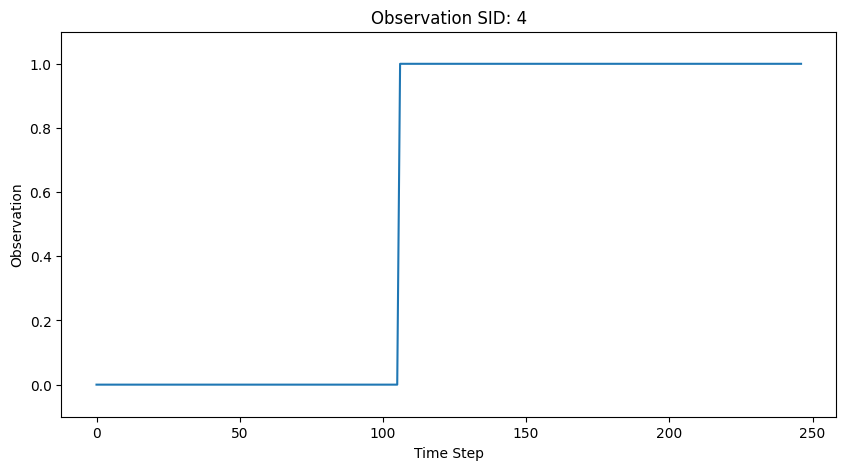

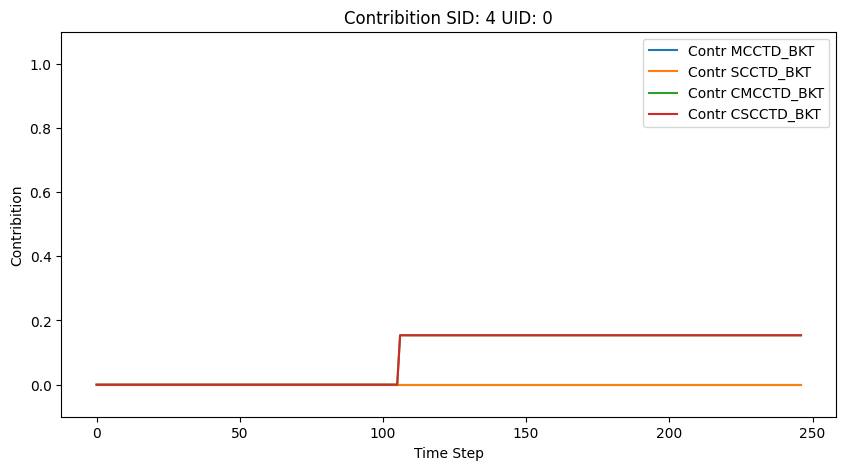

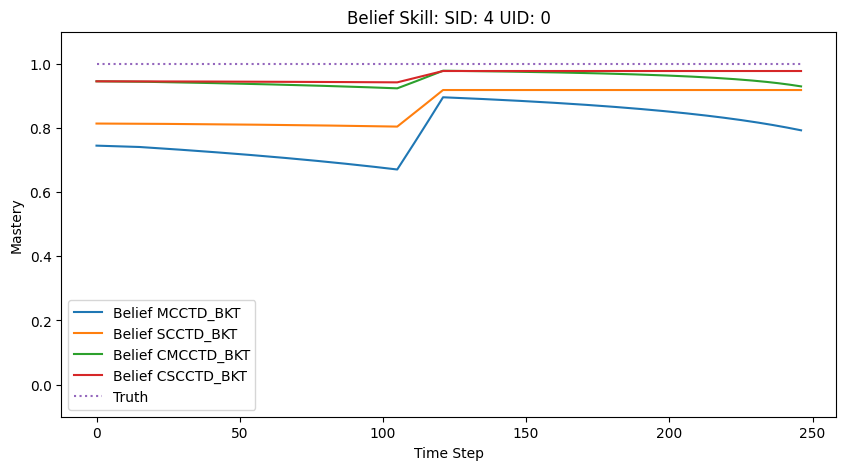

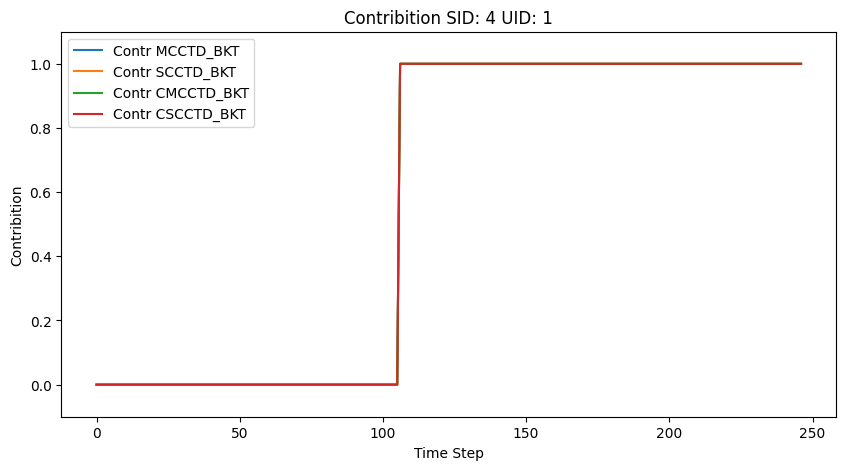

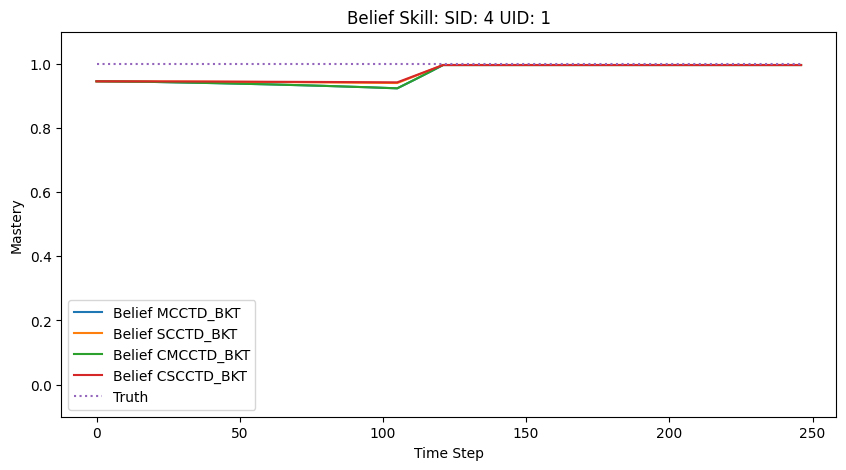

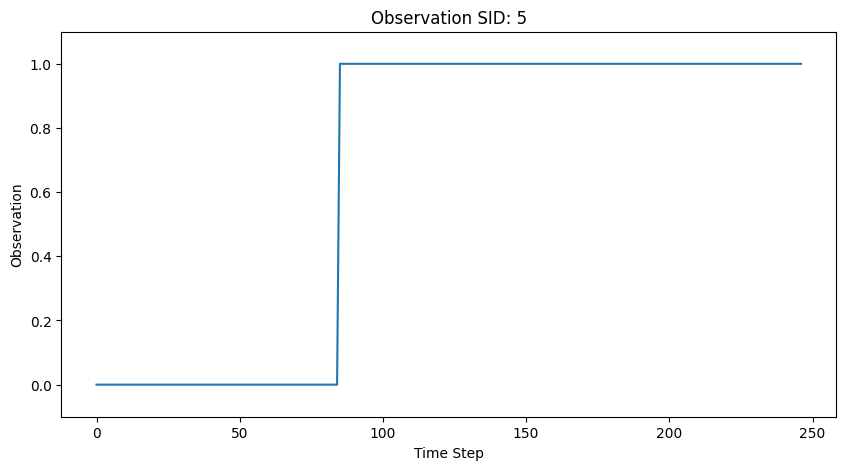

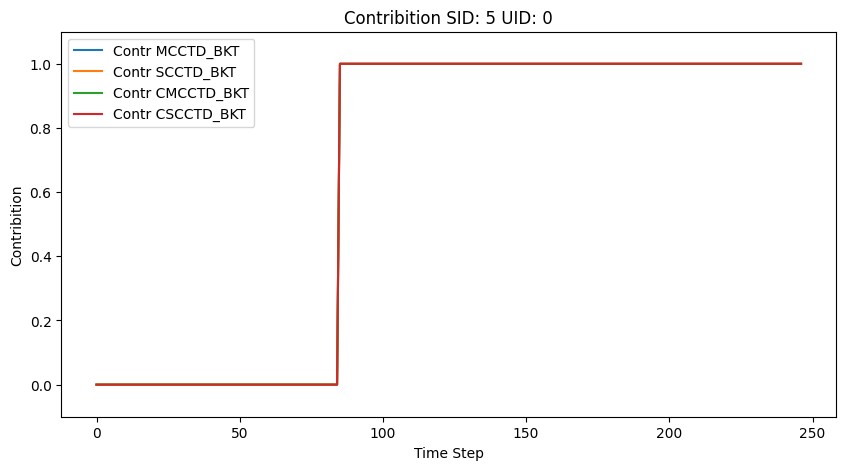

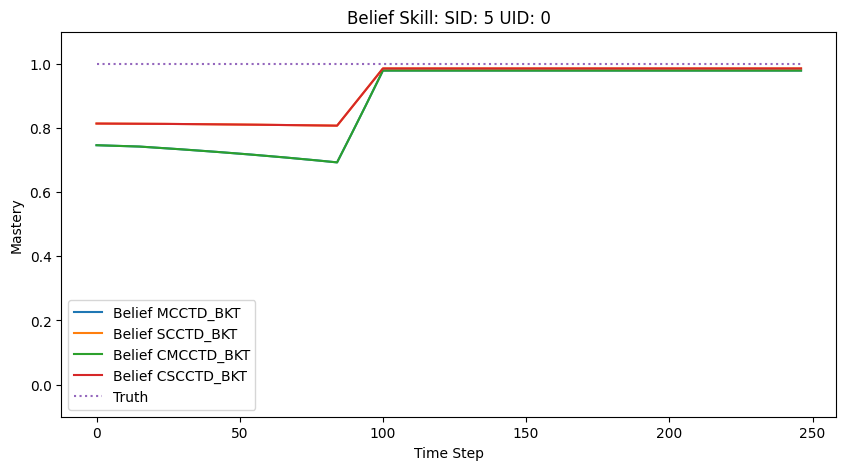

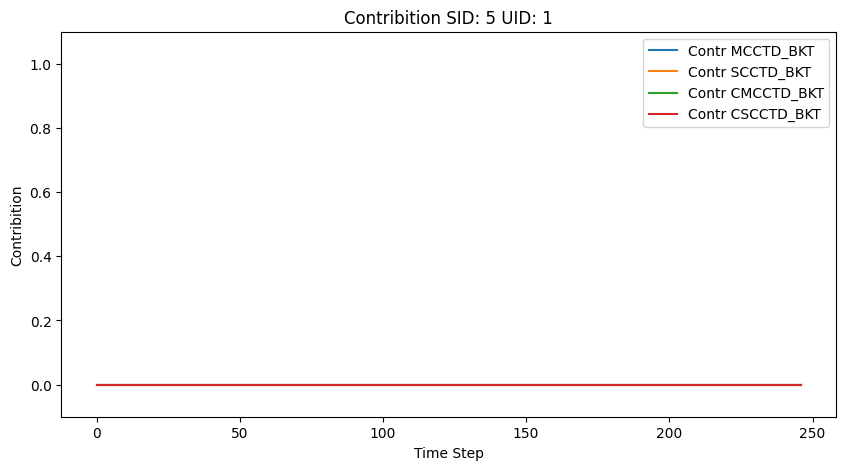

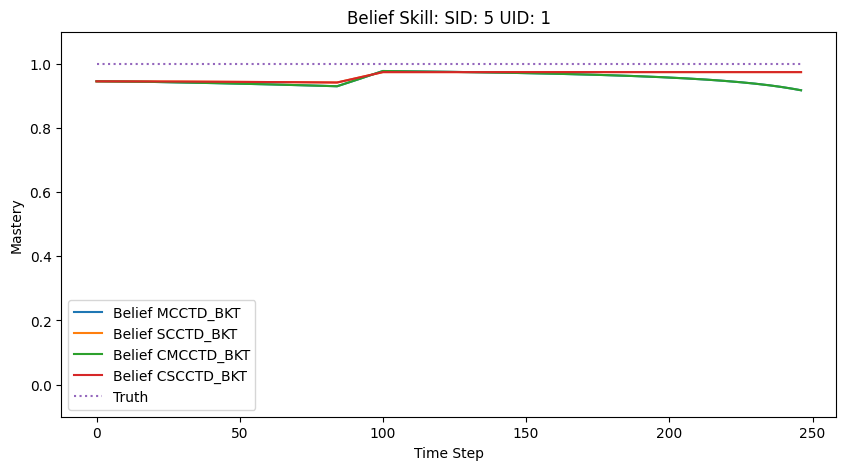

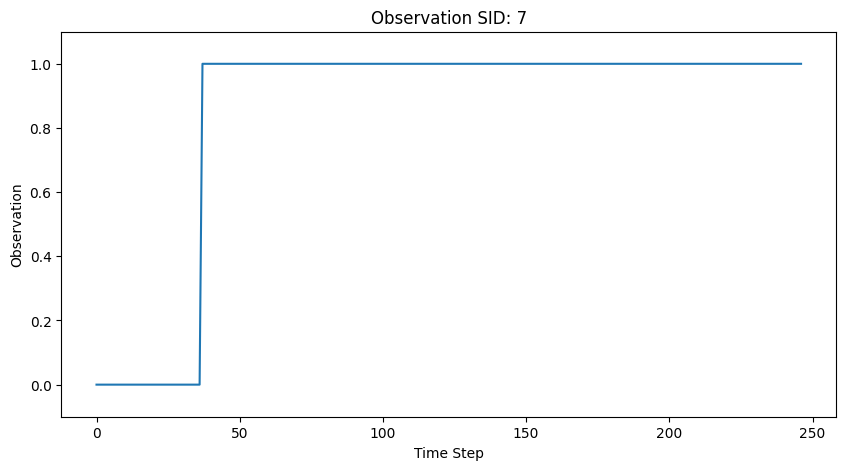

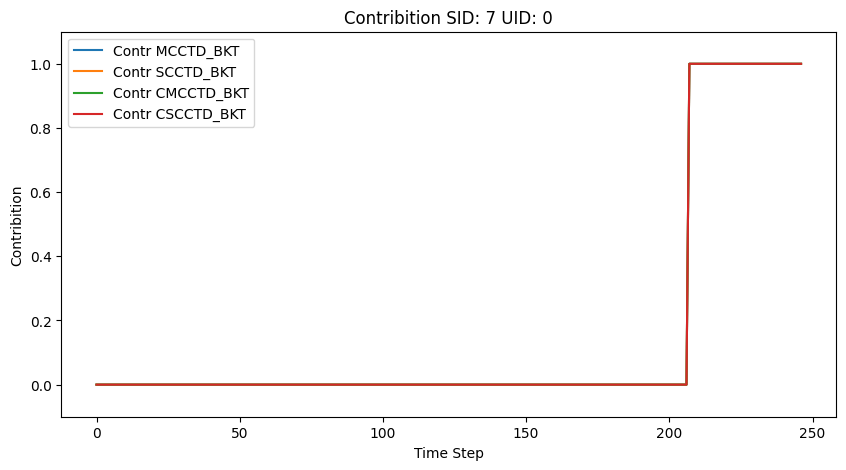

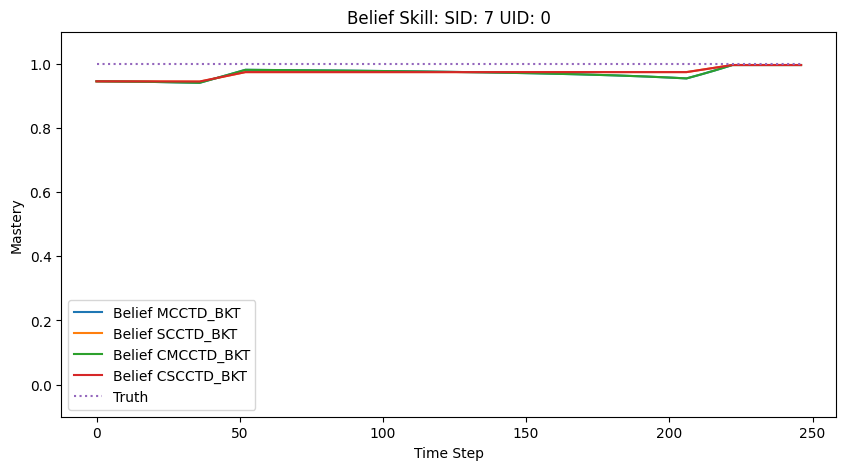

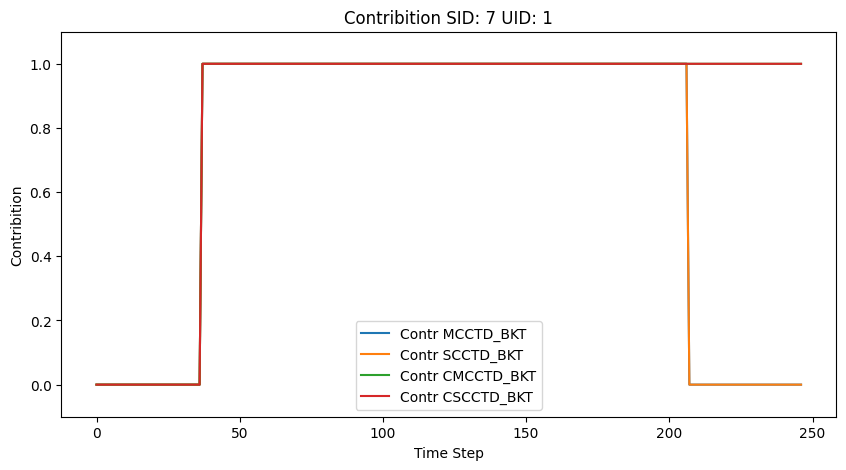

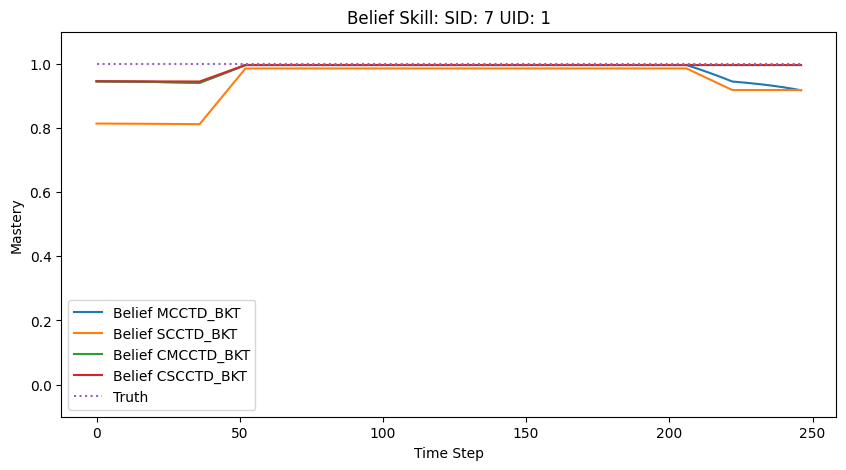

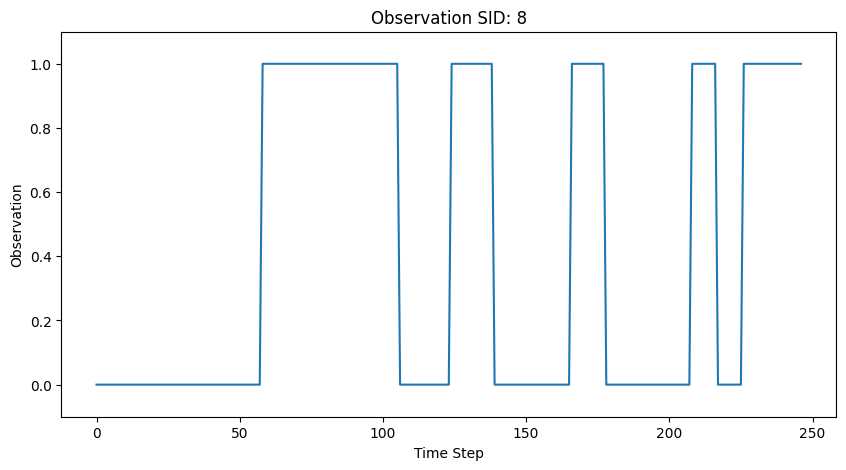

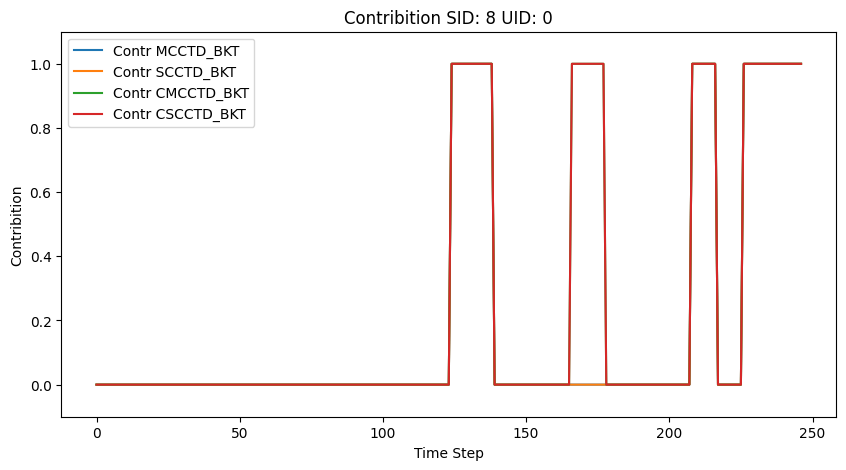

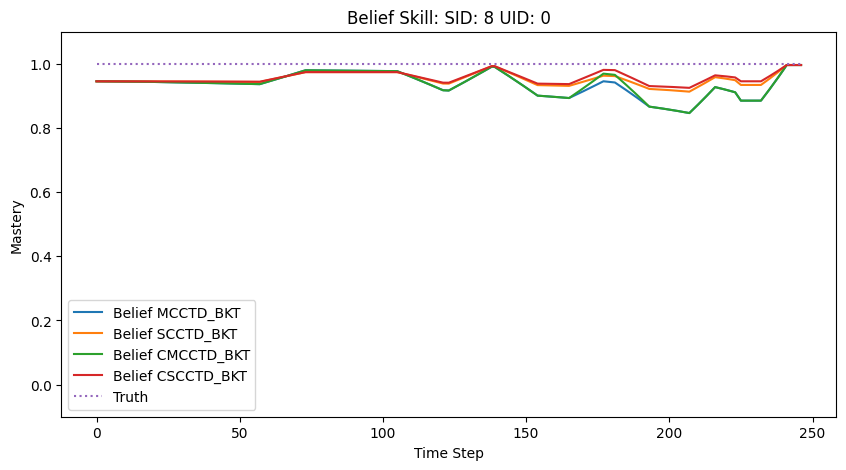

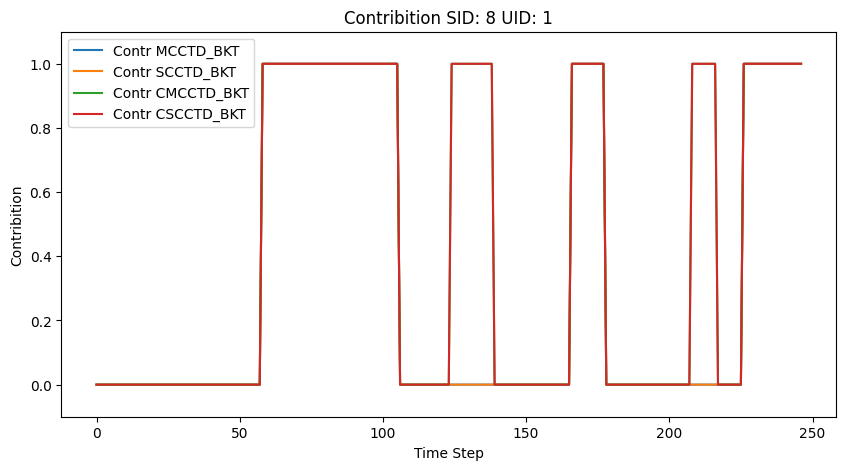

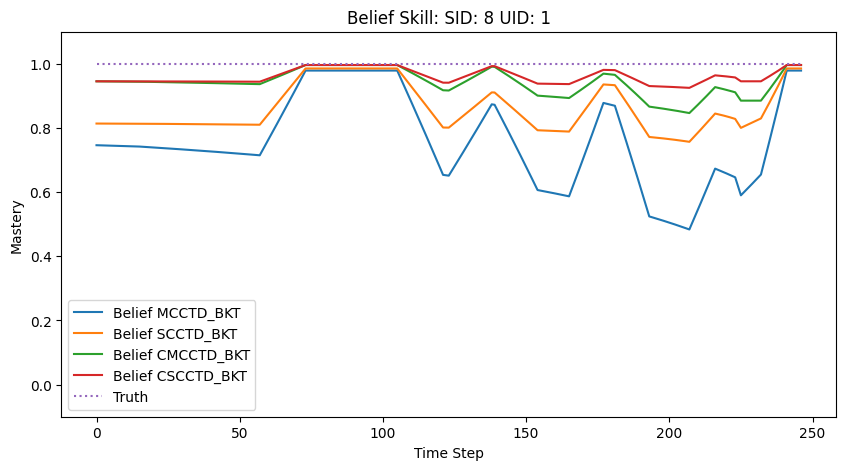

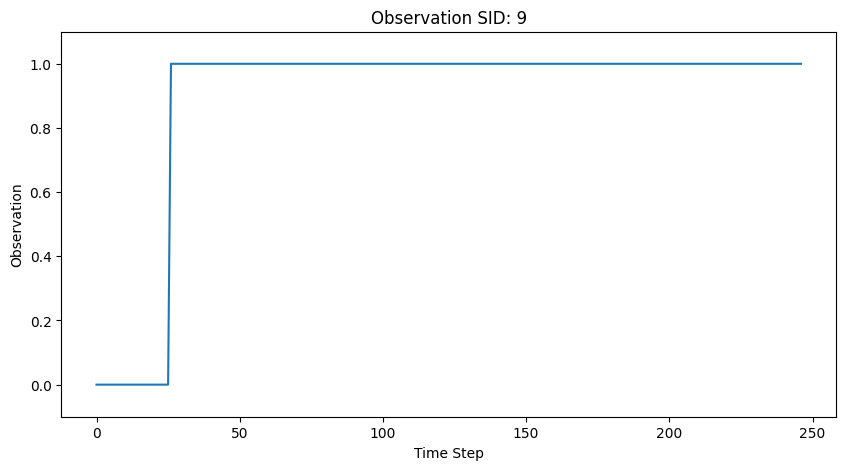

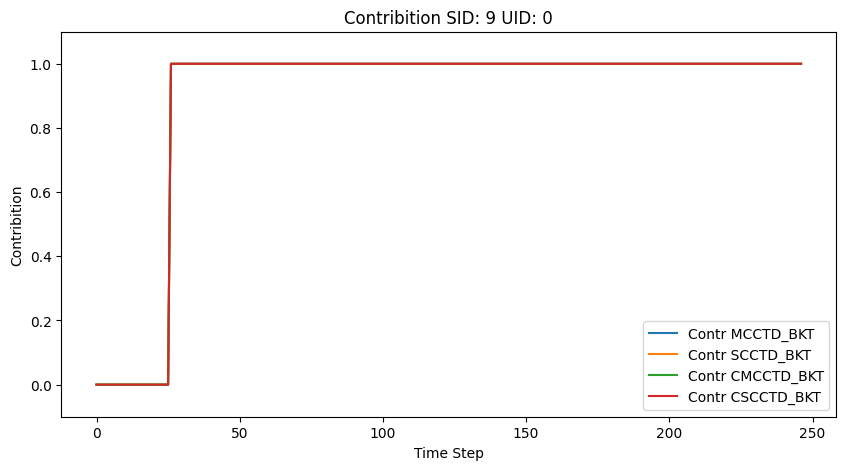

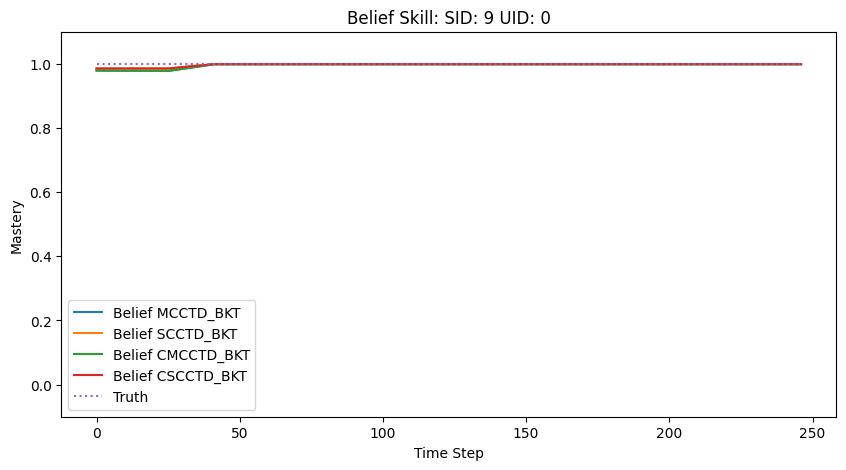

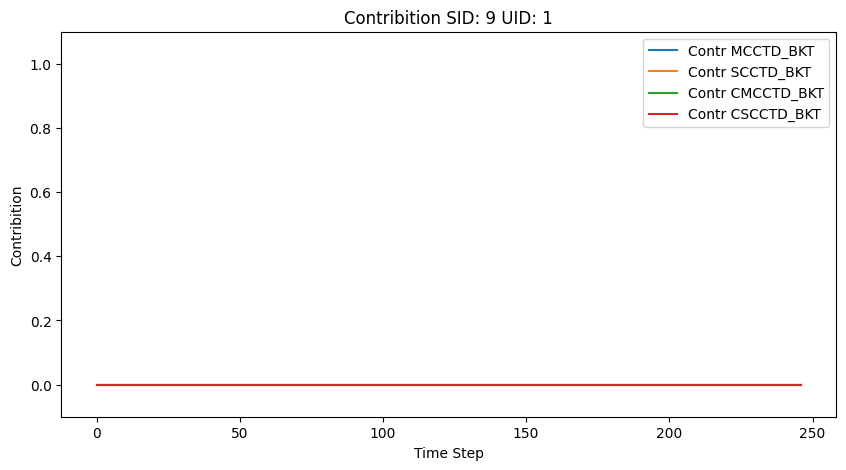

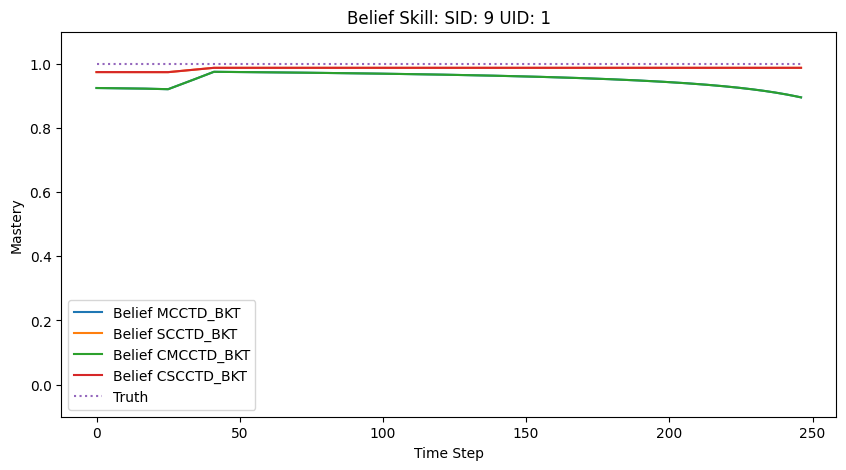

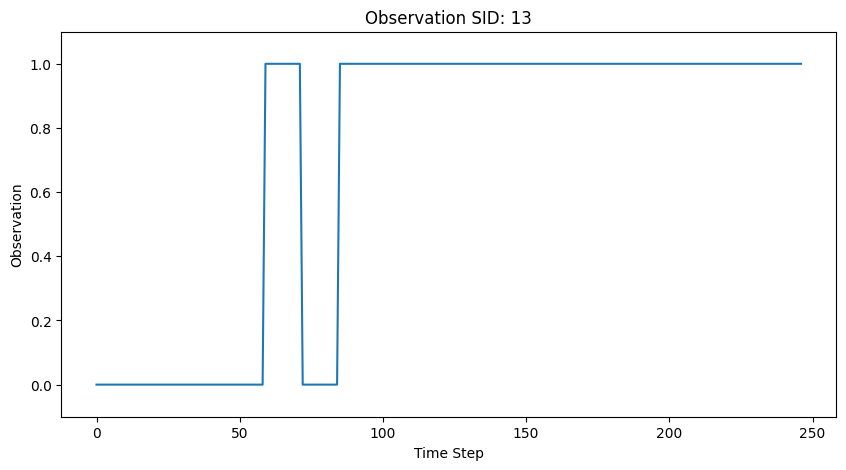

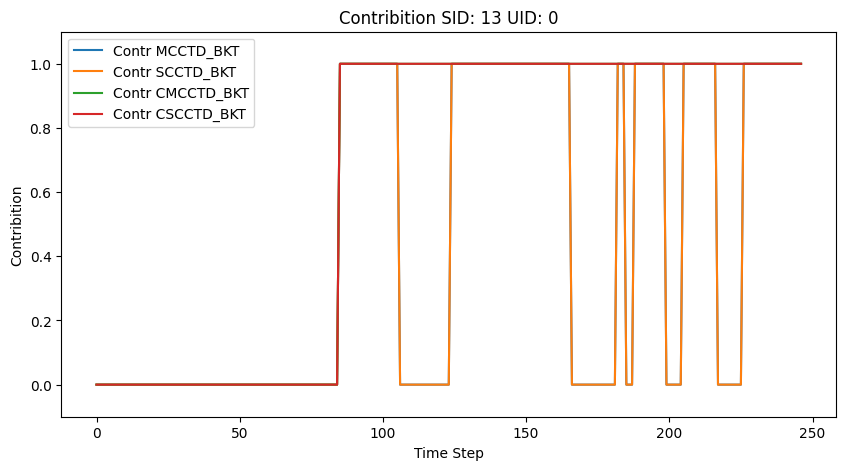

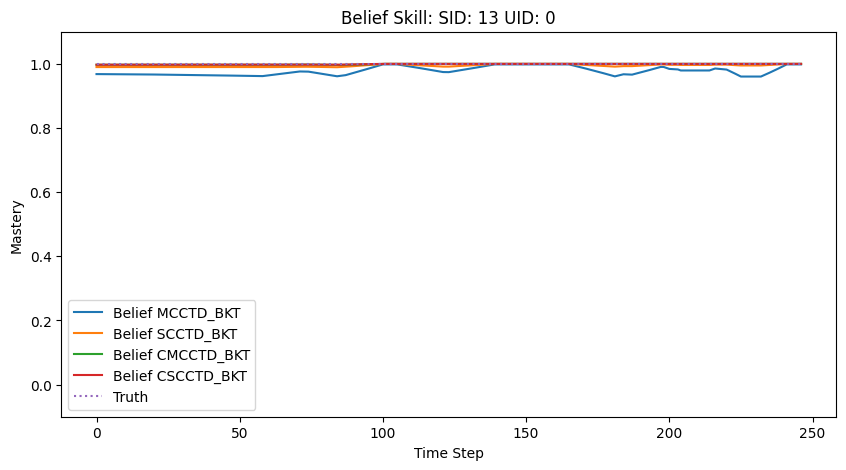

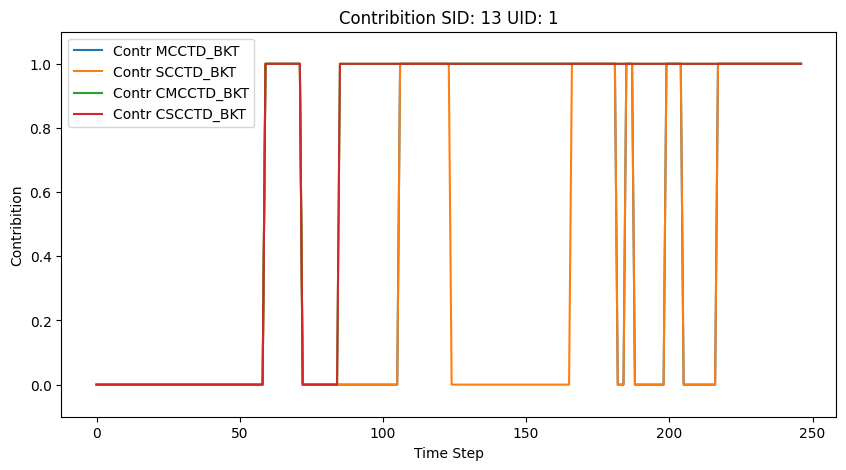

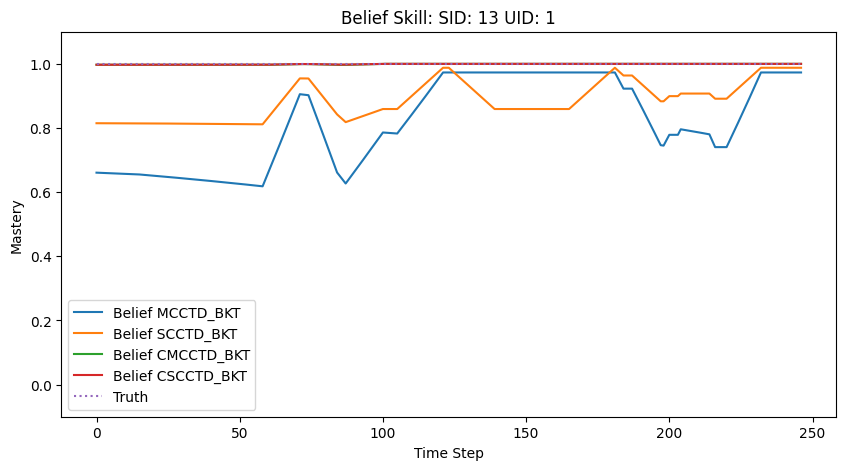

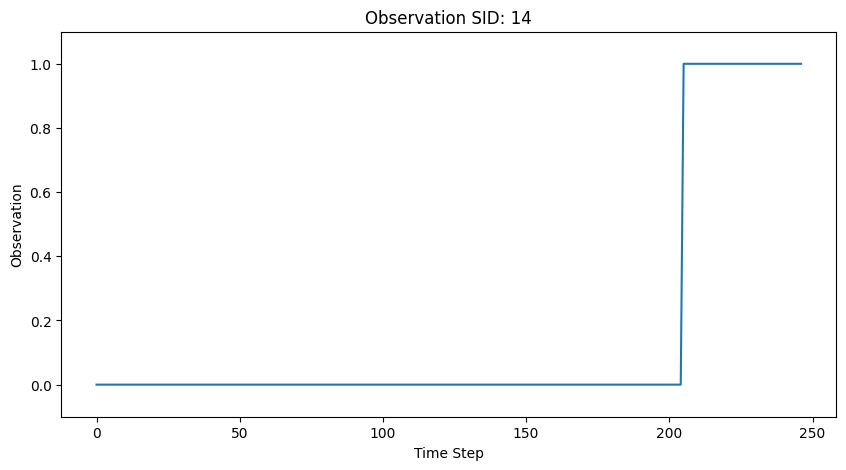

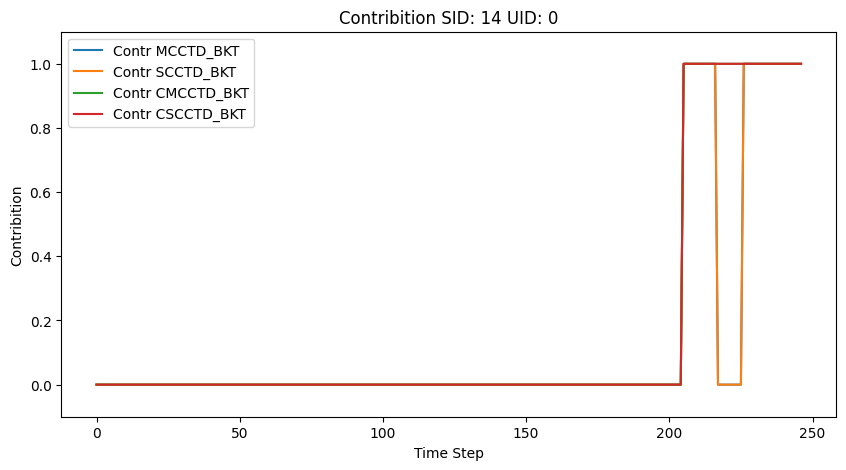

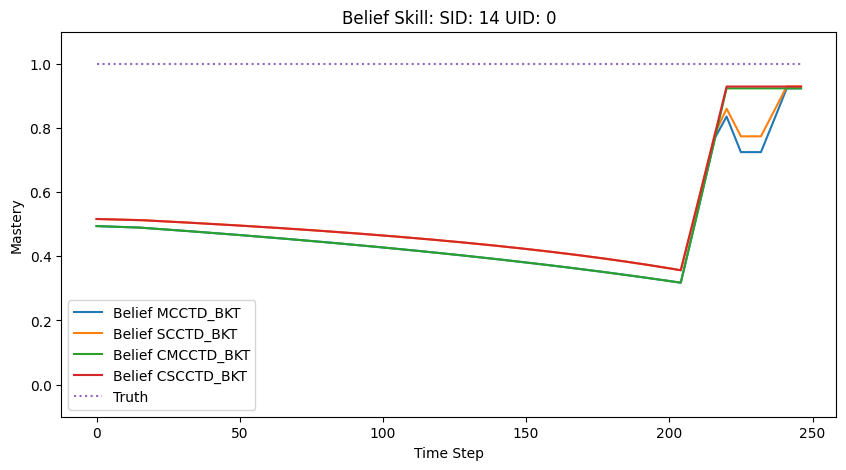

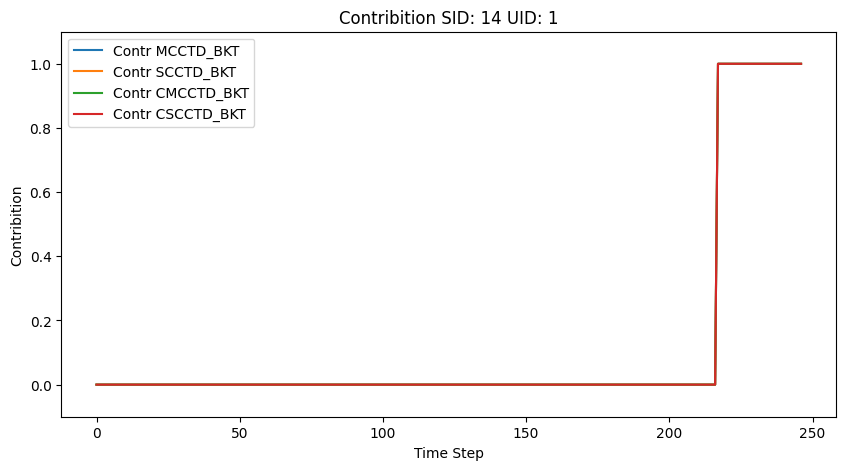

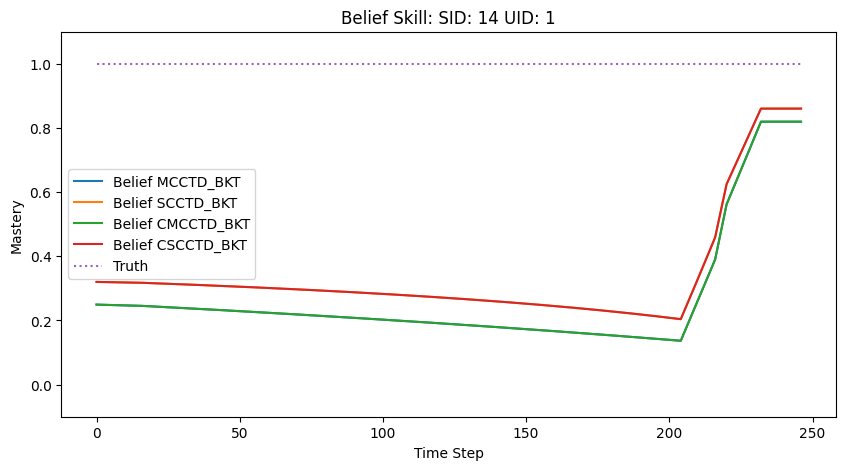

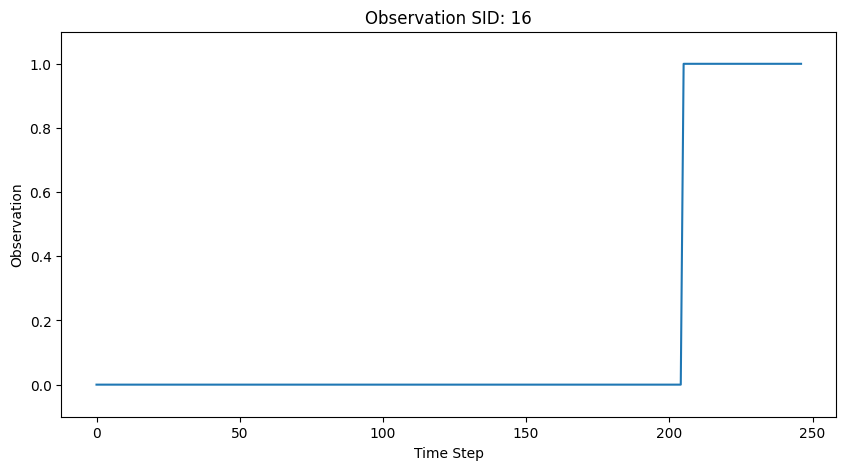

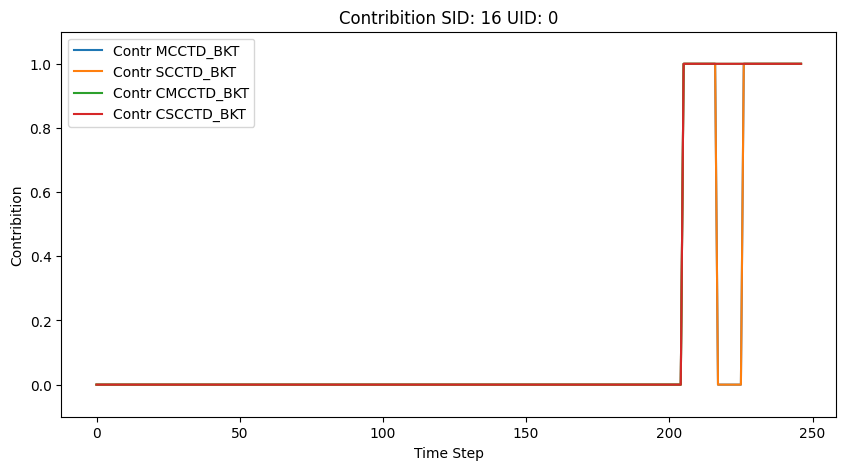

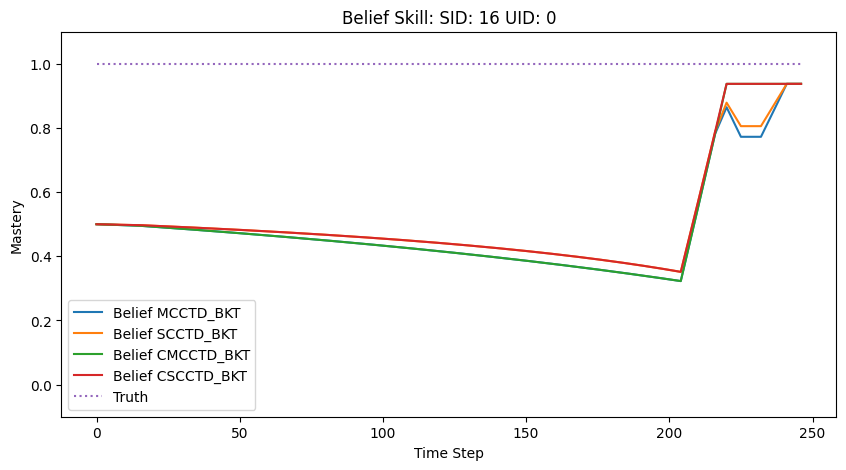

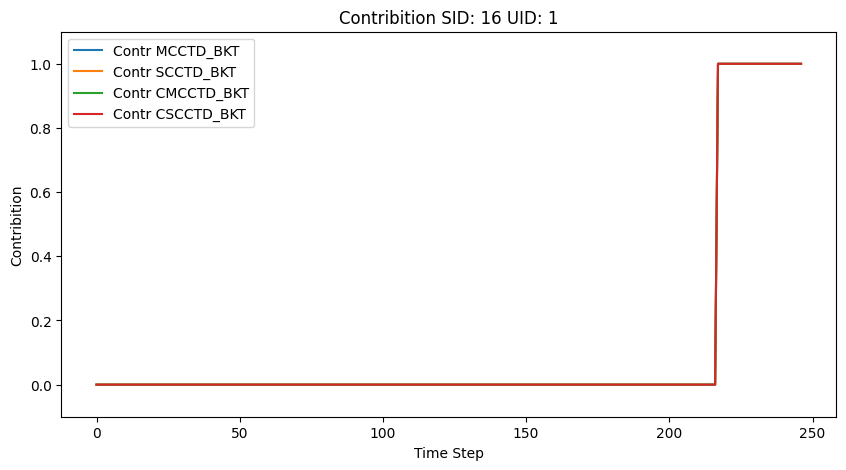

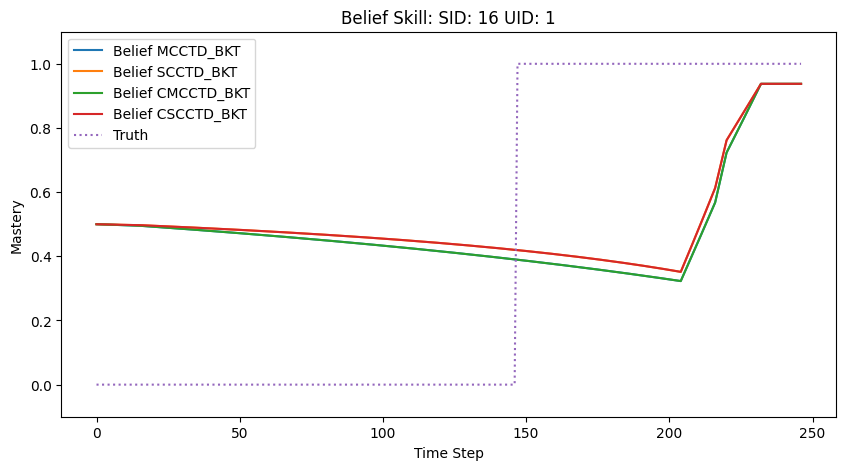

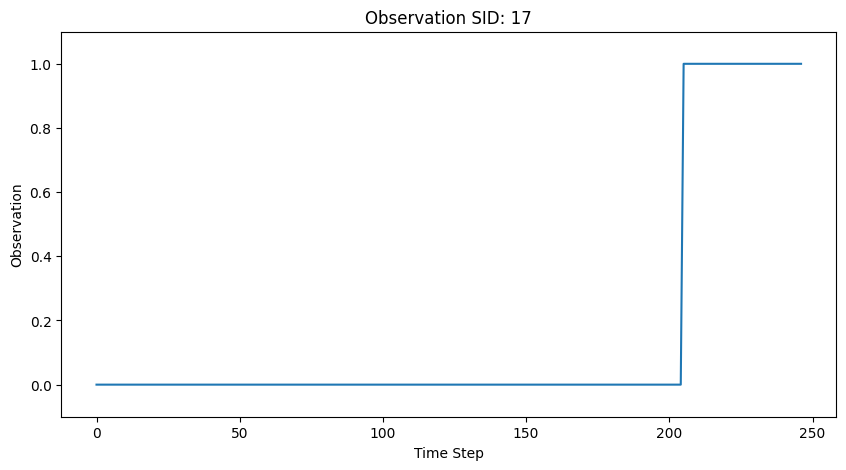

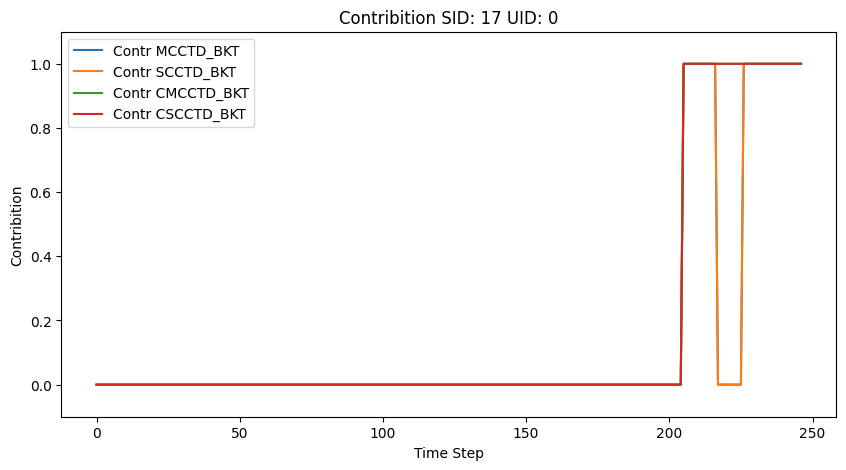

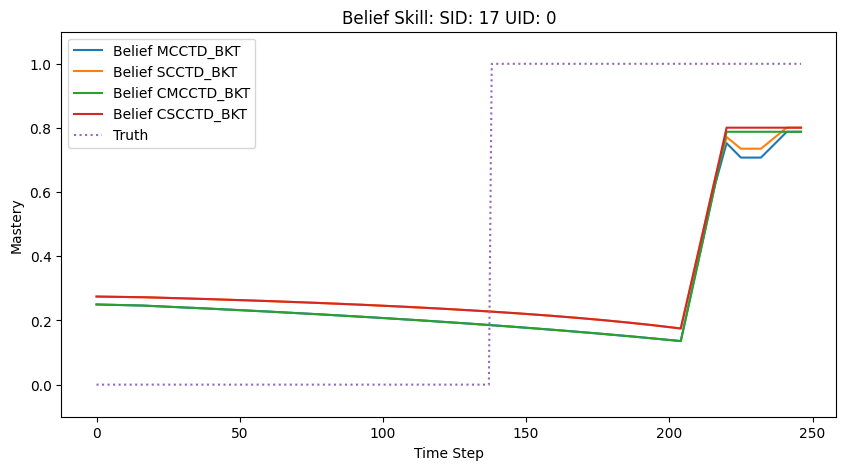

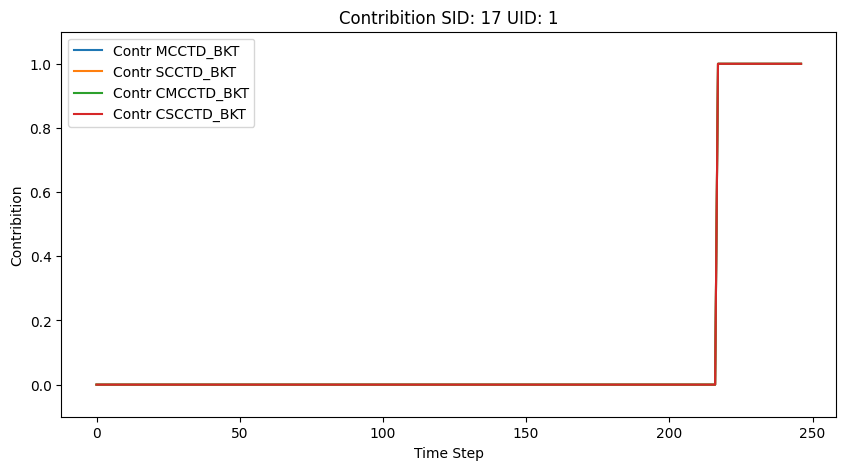

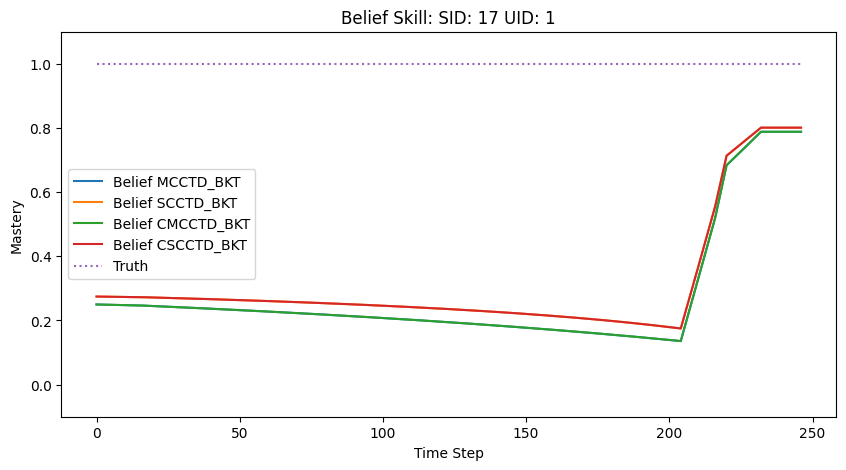

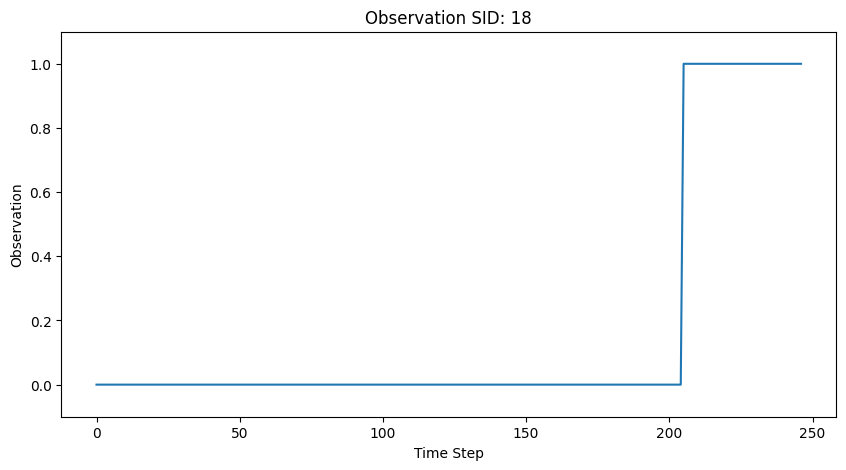

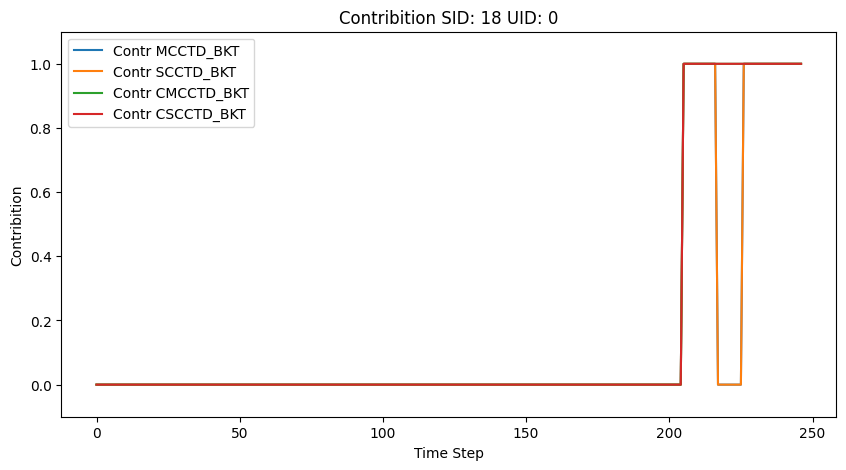

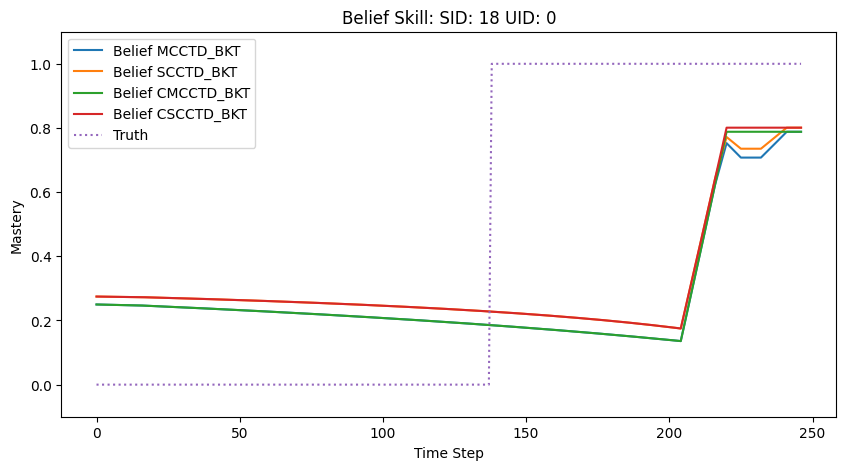

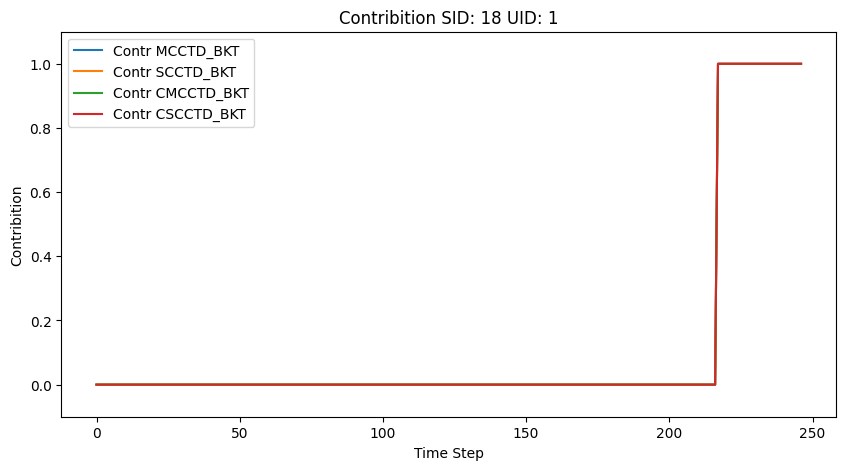

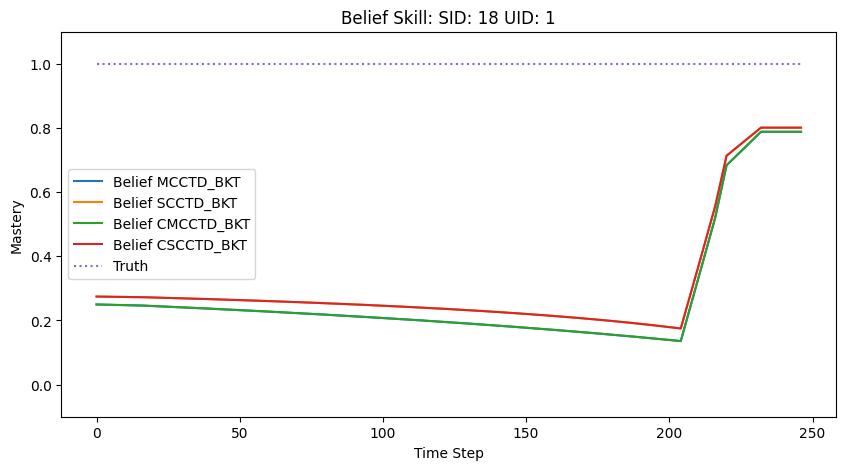

In [10]:
import various_methods
import json

anova_time_steps=[29, 59, 119, 199, 244, 359, 404]

all_sids = [4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24]
tids = ["task3"]

#unique_uids_sets = [[1, 6], [2, 3], [5, 4], [7, 8]]
unique_uids_sets = [[5, 4]]

methods_to_use = {
    "UISTS_BKT": {"usb": various_methods.UISTS_BKT, "use_history": False},
    "UIETS_BKT": {"usb": various_methods.UIETS_BKT, "use_history": False},
    "TD_BKT": {"usb": various_methods.TD_BKT, "use_history": False},
    "CTD_BKT": {"usb": various_methods.CTD_BKT, "use_history": False},
    "MCCTD_BKT": {"usb": various_methods.MCCTD_BKT, "use_history": False},
    "SCCTD_BKT": {"usb": various_methods.SCCTD_BKT, "use_history": False},
    "CMCCTD_BKT": {"usb": various_methods.CMCCTD_BKT, "use_history": True},
    "CSCCTD_BKT": {"usb": various_methods.CSCCTD_BKT, "use_history": True},
}

anova_groups = {}
kl_sums = {}

for task_name in tids:
    anova_groups[task_name] = {}
    kl_sums[task_name] = {}


for unique_uids in unique_uids_sets:
    uids = [0, 1]
    print("hey")
    for task_name in tids:
        with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_os_{task_name}.json', 'r') as f:
            os = json.load(f)
        with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_cs_{task_name}.json', 'r') as f:
            cs = json.load(f)
        with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_bs_{task_name}.json', 'r') as f:
            bs = json.load(f)
        with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_ts_{task_name}.json', 'r') as f:
            ts = json.load(f)
        with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_ms_{task_name}.json', 'r') as f:
            m = json.load(f)
        
        ms = {}

        for sid in m:
            ms[sid] = {}
            for uid in m[sid]:
                ms[sid][uid] = []
                    
                for time in ts:
                    if not time in anova_groups[task_name] and time in anova_time_steps:
                        anova_groups[task_name][time] = {}
                    if str(time) in m[sid][uid]:
                        ms[sid][uid].append(m[sid][uid][str(time)])
                    else:
                        ms[sid][uid].append(ms[sid][uid][-1])

        for method in various_methods.all_methods:
            kls = kl(bs, ms, ts, method)
            for time, kl_value in enumerate(kls):
                if time in anova_time_steps:
                    if not method in anova_groups[task_name][time]:
                        anova_groups[task_name][time][method] = [kl_value]
                    else:
                        anova_groups[task_name][time][method].append(kl_value)
                
                if not method in kl_sums[task_name]:
                    kl_sums[task_name][method] = []
                    if len(kl_sums[task_name][method]) <= time:
                        kl_sums[task_name][method].append(kl_value)
                    else:
                        kl_sums[task_name][method][time] += kl_value
                else: 
                    if len(kl_sums[task_name][method]) <= time:
                        kl_sums[task_name][method].append(kl_value)
                    else:
                        kl_sums[task_name][method][time] += kl_value
        
        if task_name == "task3":
            group_belief.plot_everything(ts, bs, os, cs, ms, chosen_methods=methods_to_use)

In [84]:
from matplotlib import pyplot as plt
import various_methods

def plot_kl_sums(kl_sums, tids, num_sim):
    kl_avgs = {}
    for tid in tids:
        kl_avgs[tid] = {}

        plt.figure(figsize=(10, 6))

        for method in all_methods:
            ts = []
            kl_avgs[tid][method] = []
            for time, value in enumerate(kl_sums[tid][method]):
                ts.append(time)

                kl_avgs[tid][method].append(value / num_sim)
            plt.plot(np.array(ts), np.array(kl_avgs[tid][method]), linestyle='-', label={method})
        
        plt.xlabel('Time Step')
        plt.ylabel('Kullback-Leibler Divergence')
        plt.legend()
        plt.show()

In [8]:
plot_kl_sums(kl_sums, tids, 4)

NameError: name 'plot_kl_sums' is not defined

In [86]:
import numpy as np
from scipy.stats import tukey_hsd

for tid in anova_groups:
    task_groups = anova_groups[tid]
    for time_step in task_groups:
        method_groups = task_groups[time_step]
        if len(method_groups["UISTS_BKT"]) != 0:
            res = tukey_hsd(method_groups["UISTS_BKT"], method_groups["UIETS_BKT"], method_groups["TD_BKT"], method_groups["CTD_BKT"], method_groups["MCCTD_BKT"], method_groups["SCCTD_BKT"], method_groups["CMCCTD_BKT"], method_groups["CSCCTD_BKT"])
            print(tid)
            print(time_step)
            print(res)



task1
29
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -1.966     1.000   -16.328    12.396
 (0 - 2)      6.089     0.847    -8.273    20.451
 (0 - 3)      1.830     1.000   -12.532    16.193
 (0 - 4)      7.277     0.700    -7.085    21.639
 (0 - 5)      7.416     0.681    -6.946    21.778
 (0 - 6)      7.388     0.685    -6.974    21.750
 (0 - 7)      7.775     0.630    -6.587    22.137
 (1 - 0)      1.966     1.000   -12.396    16.328
 (1 - 2)      8.055     0.590    -6.307    22.417
 (1 - 3)      3.797     0.986   -10.565    18.159
 (1 - 4)      9.243     0.424    -5.119    23.606
 (1 - 5)      9.382     0.406    -4.980    23.744
 (1 - 6)      9.354     0.410    -5.008    23.716
 (1 - 7)      9.741     0.361    -4.621    24.103
 (2 - 0)     -6.089     0.847   -20.451     8.273
 (2 - 1)     -8.055     0.590   -22.417     6.307
 (2 - 3)     -4.258     0.973   -18.620    10.104
 (2 - 4)      1.189    

In [ ]:
from various_methods import all_methods
import json

all_sids = [4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24]
tids = ["task1", "task2", "task3", "task4"]
unique_uids_sets = [[5, 4]]

for unique_uids in unique_uids_sets:
    uids = [0, 1]
    believed_mastery_methods = {}

    for method in all_methods:
        believed_mastery_methods[method] = {}
        for uid in uids:
            believed_mastery_methods[method][uid] = {}
            for sid in all_sids:
                believed_mastery_methods[method][uid][sid] = 0.5

    for task_name in tids:
        with open(f'user_study/values/[{unique_uids[0]}, {unique_uids[1]}]/user_study_ms_{task_name}.json', 'r') as f:
            m = json.load(f)
        
        

        video_source = f'user_study/user_study_[{unique_uids[0]}, {unique_uids[1]}]_{task_name}.mp4'
        beliefs_methods, believed_mastery_methods = run_task_on_video(video_source=video_source, task_name=task_name, uids=uids, methods=all_methods, believed_mastery_methods=believed_mastery_methods, show=True)
        

        os, cs, _, bs, ts = group_belief.get_everything(beliefs_methods=beliefs_methods)

        ms = {}

        for sid in m:
            ms[sid] = {}
            for uid in m[sid]:
                ms[sid][uid] = []
                    
                for time in ts:
                    if str(time) in m[sid][uid]:
                        ms[sid][uid].append(m[sid][uid][str(time)])
                    else:
                        ms[sid][uid].append(ms[sid][uid][-1])